In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv("./training.1600000.processed.noemoticon.csv",index_col=False
                 ,names=["senti","id","date","Q","twitter_id","texts"]) # read csv file

In [3]:
len(data)

1600000

size of dataset = 1.6million

In [4]:
df = data[["senti","texts"]].copy() #seperate text and labels
df=df.sample(frac=1) # shuffle data
df.head()

,senti,texts
853074,4,@metaglyph NP good luck with that!
1042685,4,@aplusk http://twitpic.com/65gj0 - What's with...
311265,0,SNAFU: mixup on the seller's part and they're ...
633980,0,i have such a horrible headache!! someone help
1180426,4,Bouncing on the trampoline http://twitpic.co...


# Data cleaning

In [5]:
df['senti'] = df['senti'].replace(4, 1) # replace 4 with 1
labels = np.array(df['senti']) # labels [ 0 or 1]
texts = np.array(df['texts']) # tweets [string]


In [6]:
for text in texts:
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) # remove hashtags, mentions and urls

# Pipelining data

In [7]:
char_dataset = tf.data.Dataset.from_tensor_slices((texts,labels)) # TF Dataset
for example, label in char_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b'@metaglyph NP  good luck with that!'
label:  1


In [8]:
data_size = len(df)
train_size = int(0.7 * data_size )
test_size = int(0.3 * data_size )

train_data = char_dataset.take(train_size)
test_data = char_dataset.skip(train_size)

In [9]:
buffer_size = 1000
batch_size = 512

train_data = train_data.shuffle(buffer_size).batch(batch_size)
test_data = test_data.batch(batch_size)

In [10]:
vocab_size=10000 # no. of unique words to be trained on
max_len = 280 # max tweet length
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization( # text vectorization layer [text --> int]
    max_tokens=vocab_size,output_mode="int",output_sequence_length=max_len)
encoder.adapt(train_data.map(lambda text, label: text)) # understand the text

In [11]:
for example, label in train_data.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])
 

texts:  [b'@awomansworld Sun Chips are a daily fave for me  #Fab15'
 b"&quot;we're misting each other!&quot; I'm bored already  but jose looks good in that pic."
 b'at work again  i so wish i had a job worth being excited about.']

labels:  [1 0 0]


In [12]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

9999

# Modelling

In [13]:
model = tf.keras.Sequential( [
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=32,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,kernel_regularizer=l2(0.01))),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) # stop training if no change after 5 epochs


In [14]:
history = model.fit(train_data, epochs=10,
                    validation_data=test_data, 
                    validation_steps=30,callbacks=early_stop)

Epoch 1/10
2188/2188 [==============================] - 129s 59ms/step - loss: 0.9521 - accuracy: 0.6666 - val_loss: 0.5572 - val_accuracy: 0.7589
Epoch 2/10
2188/2188 [==============================] - 125s 57ms/step - loss: 0.5177 - accuracy: 0.7688 - val_loss: 0.4994 - val_accuracy: 0.7817
Epoch 3/10
2188/2188 [==============================] - 121s 55ms/step - loss: 0.4896 - accuracy: 0.7806 - val_loss: 0.4840 - val_accuracy: 0.7853
Epoch 4/10
2188/2188 [==============================] - 126s 57ms/step - loss: 0.4766 - accuracy: 0.7857 - val_loss: 0.4746 - val_accuracy: 0.7890
Epoch 5/10
2188/2188 [==============================] - 121s 55ms/step - loss: 0.4674 - accuracy: 0.7885 - val_loss: 0.4671 - val_accuracy: 0.7878
Epoch 6/10
2188/2188 [==============================] - 121s 55ms/step - loss: 0.4607 - accuracy: 0.7908 - val_loss: 0.4619 - val_accuracy: 0.7876
Epoch 7/10
2188/2188 [==============================] - 121s 55ms/step - loss: 0.4560 - accuracy: 0.7919 - val_loss: 0

In [15]:
import matplotlib.pyplot as plt
def plot_graphs(hist,metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.legend([metric,'val_'+metric])

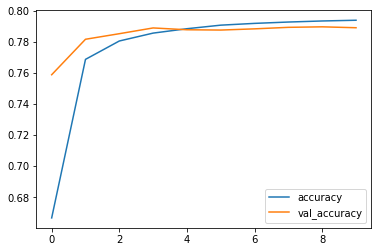

In [16]:
plot_graphs(history,'accuracy')

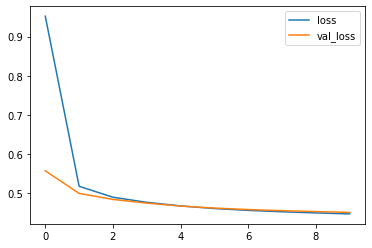

In [17]:
plot_graphs(history,'loss')